In [2]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)

# method to import git data into colab taken from:
# https://github.com/tsunrise/colab-github

Mounted at /content/drive/
Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIPNHesHoZ8yifpxV8MpOj9wzeMMzniVoRcF992tjnH5Y root@b3bd0b87503a

Please use SSH method to clone repo.


In [4]:
!git clone git@github.com:jonq-q/Comp432-GroupQ.git

Cloning into 'Comp432-GroupQ'...
remote: Enumerating objects: 18063, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 18063 (delta 2), reused 0 (delta 0), pack-reused 18054
Receiving objects: 100% (18063/18063), 1.14 GiB | 37.05 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (18018/18018), done.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls /content/Comp432-GroupQ/Dataset\ 2

'Prostate Cancer'


In [ ]:
dataset = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer /", transforms.Compose([
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

train_set, test_set = torch.utils.data.random_split(dataset,[0.7,0.3])                # splits dataset into specified ratios
train_loader = DataLoader(train_set,shuffle=True,batch_size=32, num_workers=0)         # create train loader
test_loader = DataLoader(test_set,batch_size=32, num_workers=0)  # create test loader

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

if torch.cuda.is_available():
    model = model.to('cuda')

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    current_loss = 0.0
    correct = 0
    total = 0
    round = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(inputs)
        l = loss(y_pred, labels)
        l.backward()
        optimizer.step()

        current_loss += l.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = current_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

Epoch 1/10, Loss: 1.2735, Accuracy: 73.55%
Epoch 2/10, Loss: 0.4718, Accuracy: 82.17%
Epoch 3/10, Loss: 0.4103, Accuracy: 83.79%
Epoch 4/10, Loss: 0.3535, Accuracy: 86.74%
Epoch 5/10, Loss: 0.2823, Accuracy: 89.21%
Epoch 6/10, Loss: 0.2919, Accuracy: 88.86%
Epoch 7/10, Loss: 0.2459, Accuracy: 90.81%
Epoch 8/10, Loss: 0.2275, Accuracy: 91.17%
Epoch 9/10, Loss: 0.2140, Accuracy: 92.12%
Epoch 10/10, Loss: 0.2168, Accuracy: 92.10%


In [ ]:
val_loss = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_loader:
                image = image.to('cuda')
                label = label.to('cuda')
                optimizer.zero_grad()
                y_pred = model.forward(image)
                l = loss(y_pred,label)
                running_loss += l.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(test_loader.dataset)
          epoch_loss = running_loss/len(test_loader.dataset)
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

Validation loss: 0.007431185195843379, accuracy: 0.9038888888888889
              precision    recall  f1-score   support

         MUS       0.84      0.98      0.90       636
        NORM       0.94      0.98      0.96       574
         STR       0.97      0.77      0.86       590

    accuracy                           0.91      1800
   macro avg       0.92      0.91      0.91      1800
weighted avg       0.92      0.91      0.91      1800



**Save trained model from dataset 1**

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/TrainedModel')

In [5]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/Comp 432/TrainedModel', map_location=torch.device('cuda')))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
pretrained_model.to('cuda')

with torch.no_grad():
          pretrained_model.eval()
          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = pretrained_model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

              precision    recall  f1-score   support

         MUS       0.95      0.92      0.93       636
        NORM       1.00      0.99      0.99       574
         STR       0.91      0.95      0.93       590

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

confMatrix = multilabel_confusion_matrix(true_labels, all_predictions, labels=[0, 1, 2])
print(confMatrix)

[[[1131   33]
  [  52  584]]

 [[1225    1]
  [   8  566]]

 [[1154   56]
  [  30  560]]]


In [ ]:
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

In [11]:
from typing_extensions import Self
#print(list(pretrained_model.children()))
features=list(pretrained_model.children())[:-1] #only remove fc
model_out=nn.Sequential(*features).to(device)
def for_feature(loader):
  data_tmp=[]
  label_tmp=[]

  with torch.no_grad():
      for img,label in loader:
        img=img.to(device)

        output1=model_out(img)

        data_tmp.append(output1.cpu().numpy())
        label_tmp.append(label.cpu().numpy())

  return np.vstack(data_tmp), np.hstack(label_tmp)

In [12]:
trained_feature, trained_label=for_feature(train_loader)

In [16]:
trained_feature_n = trained_feature.reshape(4200,512)

In [13]:
from scipy import stats
stats.describe(trained_label)

DescribeResult(nobs=4200, minmax=(0, 2), mean=1.0126190476190475, variance=0.6688095238095237, skewness=-0.023220605188730967, kurtosis=-1.5040893201027488)

In [16]:
#T-SNE
from sklearn.manifold import TSNE
import plotly.express as px
#plot_matrix_grid(model.coef_[0].T.reshape(-1,224,224))

In [30]:
tsne=TSNE(n_components=2, random_state=0, learning_rate='auto')
projections=tsne.fit_transform(trained_feature_n)
fig=px.scatter(projections[:,0], projections[:,1], color = trained_label, labels={"color":""}, cmap = 'hsv')
fig.show()

TypeError: ignored

In [6]:
#task 2 Pretrained ResNet18 applied to Dataset2 & 3
dataset2 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 2/Prostate Cancer/", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc1 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [9]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

**Scenario 1: Task 1 on dataset 2**

In [14]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

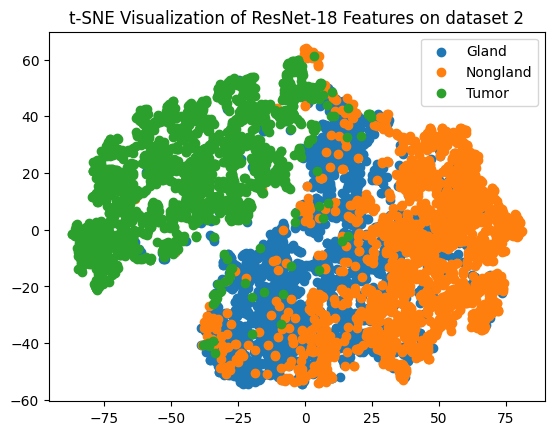

In [19]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='Gland')
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='Nongland')
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='Tumor')

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

In [ ]:
import torchvision.models as models

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG_16=models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#loss = nn.CrossEntropyLoss()
#optimizer_vgg16= optim.SGD(VGG_16.parameters(), lr=0.0001,momentum=0.9)